# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

import cv2

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size =50 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
#.1 new code added

# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

In [5]:
#function to pass extra data
def gen_def_extra(source_path, folder_list, batch_size,validation=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, nb_frames)]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            #batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data = np.zeros((batch_size, nb_frames, nb_rows, nb_cols, nb_channel)) 
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Cropping non symmetric frames
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
                    #Normal data
                    batch_data[folder,idx] = (resized)
                    
                    #batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [6]:
def generator(source_path, folder_list, batch_size,validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0, nb_frames)]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            #batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data = np.zeros((batch_size, nb_frames, nb_rows, nb_cols, nb_channel)) 
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Cropping non symmetric frames
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resized = cv2.resize(image, (nb_rows,nb_cols), interpolation = cv2.INTER_AREA)
                    #Normal data
                    batch_data[folder,idx] = (resized)
                    
                    #batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield gen_def_extra(source_path, folder_list, batch_size)
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.losses import categorical_crossentropy
from keras.optimizers import Adam


#write your model here

nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(nb_frames,nb_rows,nb_cols,nb_channel)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [11]:
#model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_').replace('.','_')
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
filepath = model_name + '.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
batch_size = 10
num_epochs = 20
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/20
 - 49s - loss: 2.0714 - categorical_accuracy: 0.2551 - val_loss: 1.4568 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2019-12-1813_56_30.139436/model-00001-2.10096-0.25641-1.45681-0.25000.h5
Epoch 2/20
 - 11s - loss: 1.5031 - categorical_accuracy: 0.3077 - val_loss: 1.5350 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2019-12-1813_56_30.139436/model-00002-1.50310-0.30769-1.53504-0.23000.h5
Epoch 3/20
 - 13s - loss: 1.4293 - categorical_accuracy: 0.3571 - val_loss: 1.3088 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2019-12-1813_56_30.139436/model-00003-1.42929-0.35714-1.30883-0.43000.h5
Epoch 4/20
 - 12s - loss: 1.0823 - categorical_accuracy: 0.5275 - val_loss: 0.9582 - val_categorical_accuracy: 0.7200

Epoch 00014: saving model to model_init_2019-12-1813_56_30.139436/model-00014-1

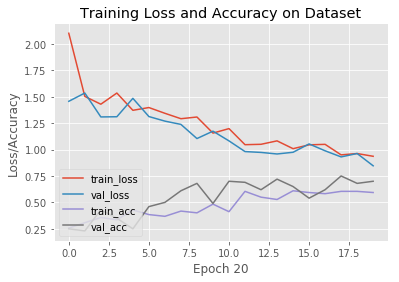

In [16]:
# with batch_size = 10 , num_epochs = 20

from matplotlib import pyplot as plt

N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch 20")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [13]:
# with batch_size = 20 , num_epochs = 30
batch_size = 20
num_epochs = 30
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/30
 - 48s - loss: 2.0723 - categorical_accuracy: 0.2551 - val_loss: 1.4586 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2019-12-1814_05_20.347176/model-00001-2.10157-0.25641-1.45862-0.25000.h5
Epoch 2/30
 - 11s - loss: 1.5005 - categorical_accuracy: 0.3297 - val_loss: 1.5515 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2019-12-1814_05_20.347176/model-00002-1.50052-0.32967-1.55155-0.23000.h5
Epoch 3/30
 - 13s - loss: 1.4538 - categorical_accuracy: 0.3187 - val_loss: 1.3394 - val_categorical_accuracy: 0.3800

Epoch 00003: saving model to model_init_2019-12-1814_05_20.347176/model-00003-1.45378-0.31868-1.33940-0.38000.h5
Epoch 4/30
 - 13s - loss: 1.4438 - categorical_accuracy: 0.3407 - val_loss: 1.2335 - val_categorical_accuracy: 0.4700

Epoch 00004: saving model to model_init_2019-12-1814_05_20.347176/model-00004-1

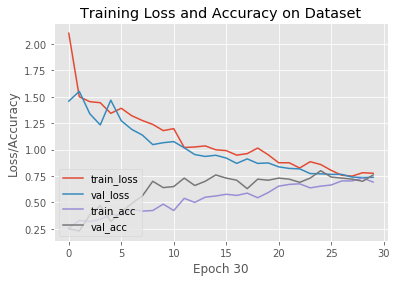

In [17]:
# with batch_size = 20 , num_epochs = 30
from matplotlib import pyplot as plt
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch 30")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [13]:
# with batch_size = 10 , num_epochs = 90
batch_size = 10
num_epochs = 90
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size = 50
Epoch 1/90
 - 160s - loss: 2.0681 - categorical_accuracy: 0.2523 - val_loss: 1.4538 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 2/90
 - 13s - loss: 1.4915 - categorical_accuracy: 0.3352 - val_loss: 1.5167 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 3/90
 - 16s - loss: 1.4447 - categorical_accuracy: 0.3132 - val_loss: 1.3328 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 4/90
 - 15s - loss: 1.4085 - categorical_accuracy: 0.3956 - val_loss: 1.2080 - val_categorical_accuracy: 0.5200

Epoch 00004: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 5/90
 - 15s - loss: 1.3308 - categorical_accuracy: 0.3736 - val_loss: 1.2816 - val_categorical_accuracy: 0.4100

Epoch 00005: saving mo


Epoch 00041: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 42/90
 - 13s - loss: 0.6608 - categorical_accuracy: 0.7198 - val_loss: 0.7171 - val_categorical_accuracy: 0.7500

Epoch 00042: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 43/90
 - 13s - loss: 0.7267 - categorical_accuracy: 0.7363 - val_loss: 0.7114 - val_categorical_accuracy: 0.7400

Epoch 00043: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 44/90
 - 13s - loss: 0.6497 - categorical_accuracy: 0.7692 - val_loss: 0.7065 - val_categorical_accuracy: 0.7400

Epoch 00044: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 45/90
 - 12s - loss: 0.6662 - categorical_accuracy: 0.7253 - val_loss: 0.7038 - val_categorical_accuracy: 0.7500

Epoch 00045: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 46/90
 - 12s - loss: 0.6897 - categorical_accuracy: 0.7253 - val_loss: 0.7024 - val_categorical_accuracy: 0.7600

Epoch 00046: saving model to model_init_2019-12-2108_0


Epoch 00083: saving model to model_init_2019-12-2108_07_55_005320.h5

Epoch 00083: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 84/90
 - 12s - loss: 0.6842 - categorical_accuracy: 0.7527 - val_loss: 0.6831 - val_categorical_accuracy: 0.7800

Epoch 00084: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 85/90
 - 13s - loss: 0.6332 - categorical_accuracy: 0.7747 - val_loss: 0.6829 - val_categorical_accuracy: 0.7800

Epoch 00085: saving model to model_init_2019-12-2108_07_55_005320.h5

Epoch 00085: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 86/90
 - 13s - loss: 0.6945 - categorical_accuracy: 0.7418 - val_loss: 0.6826 - val_categorical_accuracy: 0.7800

Epoch 00086: saving model to model_init_2019-12-2108_07_55_005320.h5
Epoch 87/90
 - 13s - loss: 0.6835 - categorical_accuracy: 0.7418 - val_loss: 0.6833 - val_categorical_accuracy: 0.7800

Epoch 00087: saving model to model_init_2019-12-2108_07_55_005320.h5

Epoch 0008

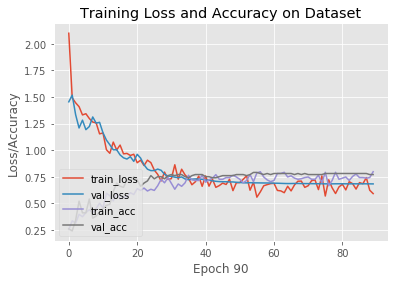

In [15]:
# with batch_size = 10 , num_epochs = 90
from matplotlib import pyplot as plt
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch 90")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

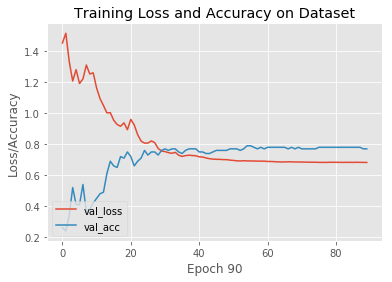

In [16]:
from matplotlib import pyplot as plt
N = num_epochs
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch 90")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
# with batch_size = 90 , num_epochs = 30
batch_size = 90
num_epochs = 30
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
